# **SPEAKER RECOGNITION**

# SIGNAL FRAMING AND MEL FREQUENCY CEPSTRAL COEFFICIENTS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import rfft,dct
import math
import os

def framing(sig,fs,frame_size,frame_start):
  # sig is readed data of a signal, fs is sampling frequency,frame_size is duration of a frame
  # frame start indicates after what duration another frame starts.
 # compute frame length and frame step (convert from seconds to samples)
  frame_length = frame_size * fs
  frame_step = frame_start * fs
  signal_length = len(sig)
  frames_overlap = frame_length - frame_step

  num_frames = np.abs(signal_length - frames_overlap) // np.abs(frame_step)
  rest_samples = np.abs(signal_length - frames_overlap) % np.abs(frame_step)

# Pad Signal to make sure that all frames have equal number of samples
# without truncating any samples from the original signal
  if rest_samples != 0:
      pad_signal_length = int(frame_step - rest_samples)
      z = np.zeros((pad_signal_length))
      pad_signal = np.append(sig, z)
      num_frames += 1
  else:
      pad_signal = sig

     # make sure to use integers as indices
  frame_length = int(frame_length)
  frame_step = int(frame_step)
  num_frames = int(num_frames)
  frames=np.zeros((num_frames,frame_length))
  k=0
  for i in range(num_frames):
    frames[i]=pad_signal[k:k+frame_length]
    k+=frame_step
  return frames# this function returns frames as output( a 2 dimensional array )


def power(frames,nfft,frame_size,fs):
  # this function calculates power series for respective frames as input
  frame_length = int(frame_size*fs)
  frames = frames * np.hamming(frame_length)
  ftrans = rfft(frames,nfft)
  fmod = np.absolute(ftrans)
  pwer = (fmod**2)/512
  return pwer


def freqtomel(f):# this function convert frequency into mel frequency
   mel=1125*math.log(1+f/700)
   return mel
def meltofreq(mel):# this function convert mel frequency into frequency
  freq=700*(math.exp(m/1125)-1)
  return freq
# nfilt is number of filters usually 26 is choosen
# nfft is number of fast fourier transform points usually 512 is choosen
def melfreqpoints(fs,nfilt,nfft):
  # this function give squence of frequencies. using this sequence we build filter banks.
  f_up=fs/2
  f_low=300
  m_up=freqtomel(f_up)
  m_low=freqtomel(f_low)
  nfilt=26
  mel_points=np.linspace(m_low,m_up,nfilt+2)
  mel_freq_points=700*np.exp(mel_points/1125)-700
  fp=np.floor((nfft)*mel_freq_points/fs)
  return fp 

def filterbank(fp,nfilt,nfft):
  # fp is filter frequency bin points
  h=np.empty((nfilt,int(nfft/2 + 1)))#h is filter bank
  for i in range(nfilt):
    for k in range(int(nfft/2 + 1)):
     
       if k < fp[i]:
           h[i][k]=0
       elif fp[i]<=k and k<=fp[i+1]:
           h[i][k]=(k-fp[i])/(fp[i+1]-fp[i])
       elif fp[i+1]<k and k<=fp[i+2]:
           h[i][k]=(fp[i+2]-k)/(fp[i+2]-fp[i+1])
       elif k>fp[i+2] and k<=256:
           h[i][k]=0
  return h


def mfccs(pwer,h):
  # this function give mfccs as output
  f_energy=np.dot(pwer,h.T)# multiplying 
  log_f_energy=np.log(f_energy)
  mfcc=(dct(log_f_energy))[:,1:13]
  return mfcc
def mfcc_final(sig,fs):
  """this function is combination of functions so that we can directly calculate mfccs by passing signal and fs.
    if you want different frame_size, frame_start, nfft, nfilt the chnges should be done here. """
  
  frame_size=0.025
  frame_start=0.01
  nfft = 512
  nfilt = 26
  frames = framing(sig,fs,frame_size,frame_start)
  pwerframes = power(frames,nfft,frame_size,fs)
  #print(pwerframes)
  fp = melfreqpoints(fs,nfilt,nfft)
  #print(fp)
  filter_bank = filterbank(fp,nfilt,nfft)
  #print(filter_bank[0])
  mfcc = mfccs(pwerframes,filter_bank)
  return mfcc




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## LINDE-BUZO-GRAY Algorithm

In [ ]:
######### lbg algoritm dist = np.linalg.norm(point1 - point2)
e = 0.01

def cb_splitting(codebook,ugm,e,z):# ugm = upgraded m and z is length of acoustic vectors
   """ This function splits each codeword in the codebook into two new codewords.
   ugm is upgraded m value and z is length of acoustic vectors choosen. """

   i,j = 0,0
   new_codebook = np.empty((ugm,z))
   while (i < ugm):
     temp = codebook[j]
     new_codebook[i] =  temp *(1+e)
     new_codebook[i+1] = temp*(1-e)
     j+=1
     i+=2
   return new_codebook  
def cluster_vectors(data,codebooks,m):
  """ this function is used to do clustering the data with respect to present codebook.
  data is array of mfccs or lpcs and m is current no of codeword in codebook.
  this function returns list of tuples of form (index of codeword matched,distortion,corresponding acoustic vector ) """
  clustervec = []
  distortion = 0
  for i in range(len(data)):
     distance = []
     for j in range(m):
        dist = np.linalg.norm(data[i] - codebooks[j])
        distance.append((j,dist,data[i]))
     distance.sort(key=lambda tup:tup[1])
     distortion += distance[0][1]
     clustervec.append(distance[0])
  mean_distr = distortion/len(clustervec)
  return clustervec,mean_distr
def finding_centroids(clustervec,codebooks,m,z):
    """ this function finds centroids of clustered data 
    clustervec is output from cluster_vectors function """
    centroids = np.zeros((m,z))
    count = np.zeros(m)
    for clusthelp in clustervec:
        for j in range(m):
          if clusthelp[0] == j:
            centroids[j] += clusthelp[2]
            count[j] +=1
          else:
            0
    for j in range(m):
      if count[j]!=0:
         centroids[j] = centroids[j]/count[j]
    return centroids
def distortion(data,codebooks,m):
  """ This function calculates minimum mean distortion of a mfccs or lpcs of their respective codebooks """
  distortion = 0
  for i in range(len(data)):
     distance = []
     for j in range(m):
        dist = np.linalg.norm(data[i] - codebooks[j])
        distance.append((j,dist))
     distance.sort(key=lambda tup:tup[1])
     distortion += distance[0][1]
  mean_distr = distortion/len(data)
  return mean_distr


def codebook(mfcc,M,z):
  """ this function is combination of above defined functions
  so that we get final codebook with just a one function call.
  if any change in e,m,thrshld are required change in this function"""

  code_book = np.zeros((1,z))
  code_book[0]= np.mean(mfcc,axis=0)
  m = 1
  e = 0.01
  thrshld = 0.01
  while (m<M):
    m = 2*m
    code_book = cb_splitting(code_book,m,e,z)
    stop = 1
    while (stop):
      cluster_vec,d = cluster_vectors(mfcc,code_book,m)
      code_book = finding_centroids(cluster_vec,code_book,m,z)
      d1 = distortion(mfcc,code_book,m)#distr_list.append(distortion(mfcc,code_book,m))
      #cond = (distr_list[-2] - distr_list[-1])/distr_list[-1]
      cond = (d-d1)/d1
      if cond < thrshld :
        stop = 0
  return code_book

#*******************end of lbg**************8
# print(code_book)
# print(distr_list)
# #print(cond)

s1.wav is matching with s1.wav
s2.wav is matching with s2.wav
s3.wav is matching with s3.wav
s4.wav is matching with s4.wav
s5.wav is matching with s5.wav
s6.wav is matching with s6.wav
s7.wav is matching with s7.wav
s8.wav is matching with s8.wav
accuracy for mfccs + lbg  is  100.0 %


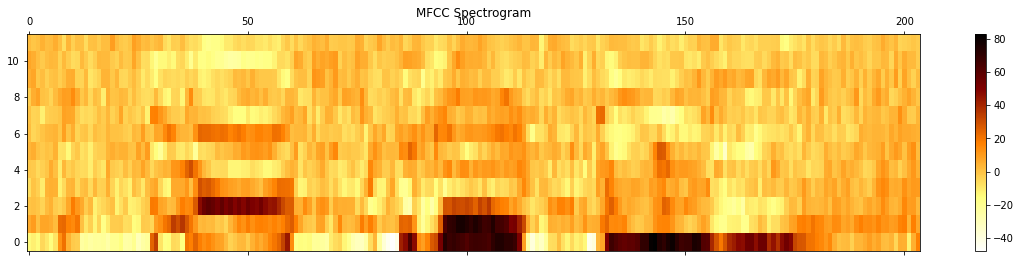

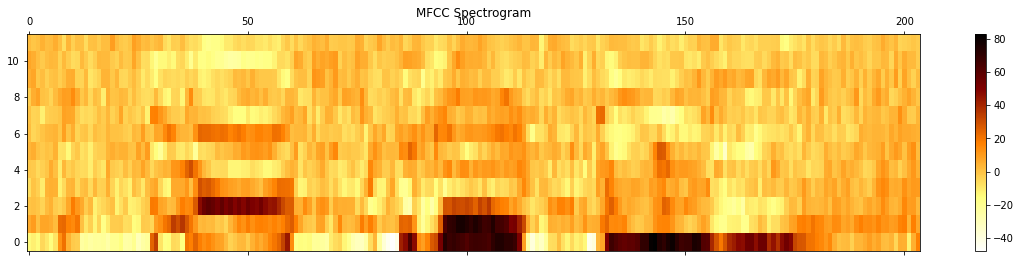

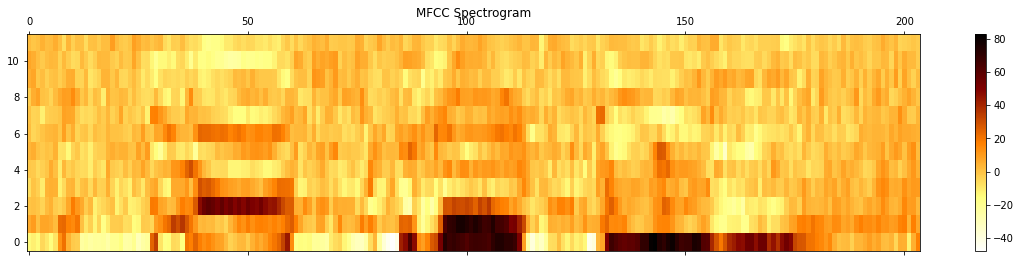

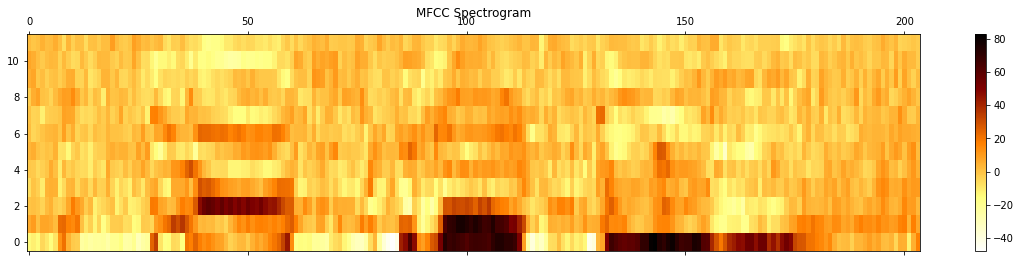

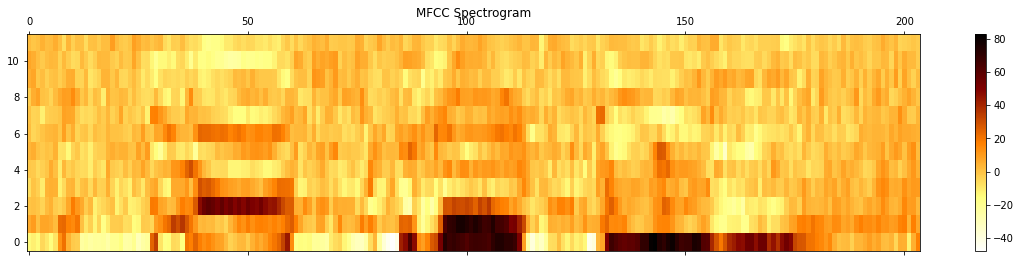

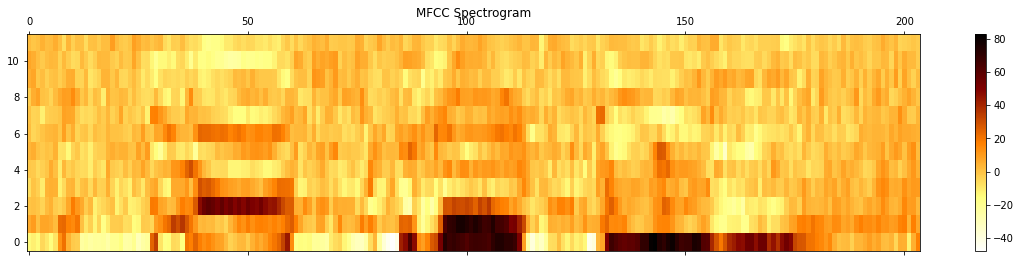

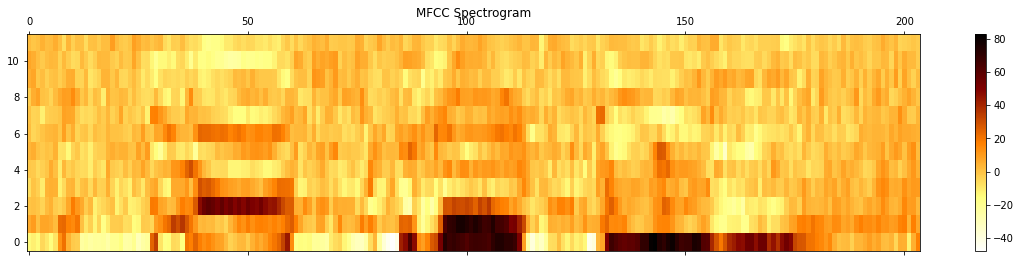

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

directory='/content/drive/MyDrive/dataset/data/train'# change this directory if you want to run on your device
M = 8
z = 12
distr_limit = 30
train_speakers = os.listdir(directory)
codebooklist = []
accuracy_list = []
# training 
for i in train_speakers:
  fs,sig = wavfile.read(directory+'/'+i)
  mfcc = mfcc_final(sig,fs)
  codebooklist.append(codebook(mfcc,M,z))
# print(codebooklist[1])
# print(train_speakers)
# testing
test_directory = '/content/drive/MyDrive/dataset/data/test'
test_speakers = os.listdir(test_directory)
speaker_features = []
# print(test_speakers)
for i in test_speakers:
  fs,sig = wavfile.read(test_directory+'/'+i)
  mfcc = mfcc_final(sig,fs)
  speaker_features.append(mfcc)
for i in range(len(test_speakers)):
  distortion_list = []
  for j in range(len(train_speakers)):
    distortion_list.append((j,distortion(speaker_features[i],codebooklist[j],M)))
  distortion_list.sort(key=lambda tup:tup[1])
  if distortion_list[0][1]<distr_limit:
      print( test_speakers[i] + " is matching with " +train_speakers[distortion_list[0][0]])
      if test_speakers[i] == train_speakers[distortion_list[0][0]]:
        accuracy_list.append(1)
      else:
        accuracy_list.append(0)

  else:
      print( test_speakers[i] + " is an imposter and min distortion obtained is  " +str(distortion_list[0][1]))
      if test_speakers[i] != train_speakers[distortion_list[0][0]]:
        accuracy_list.append(1)
      else:
        accuracy_list.append(0)
print("accuracy for mfccs + lbg  is ",100*sum(accuracy_list)/len(accuracy_list),"%")
for mfcc in speaker_features:
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
  cax = ax.matshow(
       np.transpose(speaker_features[0]),
        interpolation="nearest",
       aspect="auto",
        cmap=plt.cm.afmhot_r,
        origin="lower",
   )
  fig.colorbar(cax)
  plt.title("MFCC Spectrogram")
  plt.show()

# LINEAR PREDICTION COEEFICIENTS

In [ ]:
###linear prediction coefficients

def autocorrelation(frame,p):
  corr = np.zeros(p+1)
  n = len(frame)
  pad_frame = np.pad(frame,(0,p))
  for i in range(p+1):
    shift_frame = np.zeros(n+p)
    shift_frame[i:n+i] = frame
    corr[i] = sum(pad_frame*shift_frame)
  return corr
def yulewalker_matrix(x,p):
  """ This function returns yule walker symmetric matrix which is used to compute LPC 
  x is correlation output for 1 frame and p is no of lpcs chosen """
  R = np.empty((p,p)) 
  for i in range(p): 
    for j in range(p): 
      R[i,j] = x[np.abs(j-i)]   

  return R
def lpc(frames,p):
  lpcs = np.zeros((len(frames),p))
  n = len(frames[0])
  for i in range(len(frames)):
    corr_for_1frame = autocorrelation(frames[i],p)
    R = yulewalker_matrix(corr_for_1frame,p)
    r = -corr_for_1frame[1:]
    lpcs[i] = np.dot(np.linalg.inv(R),r.T)
    lpcs[i] = lpcs[i] / np.max(np.abs(lpcs[i]))
  lpcs = lpcs#/np.max(lpcs)
  return lpcs
# fs,sig = wavfile.read('s1.wav')
# frames = framing(sig,fs,0.025,0.01)
# lpcs = lpc(frames,13)
# print(lpcs)
#print(frames)
# frame = np.arange(1,10,1)
# print(frame)
# print(autocorrelation(frame,5))

In [ ]:
# lpcs + lbg
directory='/content/drive/MyDrive/dataset/data/train'
M = 8
distr_limit = 0.7
train_speakers = os.listdir(directory)
codebooklist = []
accuracy_list = []
# Training
for i in train_speakers:
  fs,sig = wavfile.read(directory+'/'+i)
  frames = framing(sig,fs,0.025,0.01)
  lpcs = lpc(frames,13)
  codebooklist.append(codebook(lpcs,M,13))
# testing
test_directory = '/content/drive/MyDrive/dataset/data/test'
test_speakers = os.listdir(test_directory)
speaker_features = []
#print(test_speakers)
for i in test_speakers:
  fs,sig = wavfile.read(test_directory+'/'+i)
  frames = framing(sig,fs,0.025,0.01)
  lpcs = lpc(frames,13)
  speaker_features.append(lpcs)
for i in range(len(test_speakers)):
  distortion_list = []
  for j in range(len(train_speakers)):
    distortion_list.append((j,distortion(speaker_features[i],codebooklist[j],M)))
  distortion_list.sort(key=lambda tup:tup[1])
  if distortion_list[0][1]<distr_limit:
      print( test_speakers[i] + " is matching with " +train_speakers[distortion_list[0][0]] + "distortion is "+str(distortion_list[0][1]))
      if test_speakers[i] == train_speakers[distortion_list[0][0]]:
        accuracy_list.append(1)
      else:
        accuracy_list.append(0)
  else:
      print( test_speakers[i] + " is an imposter and min distortion obtained is  " +str(distortion_list[0][1]))
      if test_speakers[i] != train_speakers[distortion_list[0][0]]:
        accuracy_list.append(1)
      else:
        accuracy_list.append(0)
print("accuracy for lpcs + lbg is ",100*sum(accuracy_list)/len(accuracy_list),"%")

s1.wav is matching with s1.wavdistortion is 0.6027632594509406
s2.wav is matching with s2.wavdistortion is 0.6032151789313441
s3.wav is matching with s3.wavdistortion is 0.40566458090020546
s4.wav is matching with s4.wavdistortion is 0.4295005610203914
s5.wav is matching with s5.wavdistortion is 0.4759311723269076
s6.wav is matching with s6.wavdistortion is 0.3966163272334043
s7.wav is matching with s7.wavdistortion is 0.49357017233170875
s8.wav is matching with s8.wavdistortion is 0.4767425609636654
accuracy for lpcs + lbg is  100.0 %
